In [1]:
import numpy as np
import h5py

import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt

import astro_helper as ah
from GalDatasets import GalDataset
from train_flow import standarize_data

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import rc
plt.style.use('bmh')
cmap = mpl.colormaps['viridis']  # Example: 'viridis' colormap
rc('font',**{'family':'DejaVu Sans','sans-serif':['Helvetica']})

In [108]:
input_features = sorted([
    'kappas',
    'weights',
    #'midplane-dens', 'midplane-stellar-dens',
    #'midplane-Pturb', 'midplane-Pth',
    #'midplane-veldispz', 'midplane-veldisp3D'
])
log_features = [
    'kappas',
    'weights', 
    #'midplane-dens', 'midplane-stellar-dens',
    #'midplane-Pturb', 'midplane-Pth',
    #'midplane-veldispz', 'midplane-veldisp3D',
    #'midplane-SFR-dens'
]
output_features = ['midplane-SFR-dens']
galaxy_types = sorted(['NGC300', 'ETG-vlowmass'])#, 'ETG-lowmass', 'ETG-medmass', 'ETG-himass'])

In [109]:
gals = GalDataset(
    input_features=input_features,
    output_features=output_features,
    galaxy_types=galaxy_types,
    snap_frac=0.2
)

In [110]:
filenames = gals.get_filenames(galaxy_type='MW', feature="midplane-dens")
print(len(filenames))

61


In [111]:
idcs_usable_px = gals.get_idcs_usable_px('MW')
print(idcs_usable_px)

[  29019   33694   50810 ... 6418975 6418976 6442009]


In [112]:
print(gals.get_num_usable_px('MW'))
print(gals.get_num_usable_px('ETG-vlowmass'))
print(gals.get_num_usable_px('ETG-medmass'))

2015
24667
38200


In [113]:
print(gals.min_num_usable_px)

23013


In [114]:
input_features, output_features = gals[0]
print(len(input_features), len(output_features))

50 50


In [115]:
print(len(gals))

122


# show input/output properties of a random sample of snapshots, equally-sized for different galaxies, with pixels below the star formation cut-off removed

In [116]:
print(gals.min_num_usable_px)

23013


In [117]:
input_dict, output_dict = gals.get_data_as_1d()

In [118]:
print(input_dict)

{'kappas': tensor([6.5194e-15, 5.4578e-15, 2.3373e-15,  ..., 2.3043e-15, 2.1102e-15,
        9.1100e-16], dtype=torch.float64), 'weights': tensor([8.1198e-11, 2.2090e-11, 3.3151e-12,  ..., 9.7458e-12, 6.9786e-12,
        9.5556e-12], dtype=torch.float64)}


/tmp/ipykernel_1265825/2802193634.py:1: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(input_dict['kappas']),


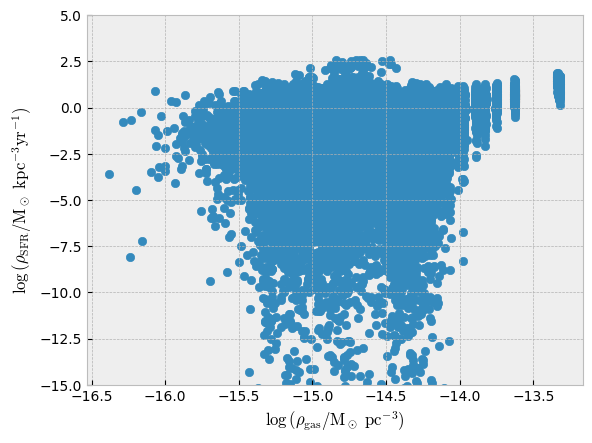

In [119]:
plt.scatter(np.log10(input_dict['kappas']),
            np.log10(output_dict['midplane-SFR-dens']))
plt.xlabel(r'$\log{(\rho_{\rm gas}/{\rm M}_\odot~{\rm pc}^{-3})}$')
plt.ylabel(r'$\log{(\rho_{\rm SFR}/{\rm M}_\odot~{\rm kpc}^{-3}{\rm yr}^{-1})}$')
plt.ylim([-15., 5.])
plt.show()

# check what the data looks like once standarized

In [20]:
X = np.stack([
    np.log10(feature) if key in log_features else feature for key, feature in input_dict.items()
], axis=1)
Y = np.stack([
    np.log10(feature) if key in log_features else feature for key, feature in output_dict.items()
], axis=1)

/tmp/ipykernel_206535/3025719563.py:2: RuntimeWarning: divide by zero encountered in log10
  np.log10(feature) if key in log_features else feature for key, feature in input_dict.items()


In [21]:
X, Y, norm_dict = standarize_data(X, Y)

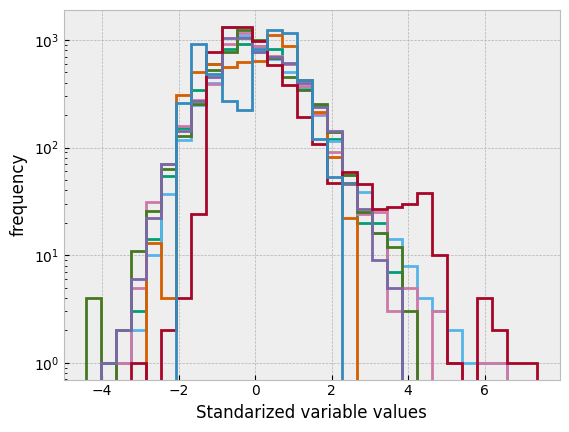

In [22]:
plt.hist(X, bins=30, histtype='step', lw=2, log=True)
plt.xlabel(r'Standarized variable values')
plt.ylabel(r'frequency')
plt.show()